# practicalMixGaussC

The goal of this notebook is to fit a mixture of gaussians model to some multi-dimensional data. To do this, we will first generate some data from a known mixture of gaussians model and fit our own mixture of gaussians model to the generated data. The parameters from our estimated mixture of gaussians model should roughly match those of the original known model. 

In [37]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
from scipy.stats import norm 
from scipy.stats import multivariate_normal
import time
import sys
flt_min = sys.float_info.min

%matplotlib inline

## Construct Ground Truth Mixture of Gaussians Model and Plot Some Points

Define some true parameters for our grounf truth mixture of $k$ Gaussians model. We will represent the 
mixtures of Gaussians as a python dictionary. The mean field is a $d \times k$ matrix and the cov field is a 
$d \times d \times k$ matrix.

In [38]:
mixGaussTrue = dict()
mixGaussTrue['k'] = 3
mixGaussTrue['d'] = 2
mixGaussTrue['weight'] = np.array([0.1309, 0.3966, 0.4725])
mixGaussTrue['mean'] = np.array([[ 4.0491 , 4.8597],[ 7.7578 , 1.6335],[ 11.9945, 8.9206]]).T
mixGaussTrue['cov'] = np.reshape([0.5, 0.25], newshape=(1,1,2))
mixGaussTrue['cov'] = np.zeros(shape=(mixGaussTrue['d'],mixGaussTrue['d'],mixGaussTrue['k']))
mixGaussTrue['cov'][:,:,0] = np.array([[  4.2534, 0.4791], [0.4791, 0.3522]])
mixGaussTrue['cov'][:,:,1] = np.array([[  0.9729, 0.8723],[  0.8723,  2.6317]])
mixGaussTrue['cov'][:,:,2] = np.array([[  0.9886, -1.2244],[ -1.2244, 3.0187]])

**drawEMData2d**, **sampleFromDiscrete**, **getGaussian2SD**, and **drawGaussianOutline** are helper functions.

In [39]:
def sampleFromDiscrete(probDist):     
    """
    Draws a random sample from a discrete probability distribution using a rejection sampling method.  
    
    Keyword arguments:
    probDist -- discrete probability ditrubtion to sample from.
    
    Returns: 
    r -- sampled point.
    """
    nIndex = len(probDist)                                                                 
    while True:                                                                            
        #choose random index                                                               
        r=int(np.floor(np.random.uniform()*nIndex))                                        
        #choose random height                                                              
        randHeight = np.random.uniform()                                                   
        #if height is less than probability value at this point in the                     
        # histogram then select                                                            
        if randHeight<probDist[r]:                                                         
            break                                                                          
    return r                                                                               

In [40]:
def getGaussian2SD(m,s,angle1):
    """
    Find position of in xy co-ordinates at 2SD out for a certain angle.
    """
  
    if s.shape[1] == 1:
        s = diag(s)

    vec = np.array([np.cos(angle1), np.sin(angle1)])
    
    factor = 4/(vec@np.linalg.inv(s)@vec.T)
    
    x = np.cos(angle1) * np.sqrt(factor)
    y = np.sin(angle1) * np.sqrt(factor)

    x = x + m[0]
    y = y + m[1]
                
    return x,y

In [41]:
def drawGaussianOutline(m,s,w):
    """
    Draw 2DGaussian
    """
    angleInc = 0.1    
    c = (0.9*(1-w), 0, 0)

    for cAngle in np.arange(0,2*np.pi,angleInc):         
        angle1 = cAngle
        angle2 = cAngle+angleInc
        x1, y1 = getGaussian2SD(m,s,angle1)
        x2, y2 = getGaussian2SD(m,s,angle2)
        plt.plot([x1, x2],[y1, y2],'-',linewidth=2,color=c)                 
    return

In [42]:
def drawEMData2d(data,mixGauss):
    """
    Plot the data plot the mixtures of Gaussian model, mixGauss, on top of it.
    
    Keyword arguments:
    data -- d by n matrix of data points.
    mixGauss -- dict with mixture of gaussian information.
    
    """
    #set(gcf,'Color',[1 1 1])
    plt.cla() 
    plt.plot(data[0,:],data[1,:],'k.')

    for cGauss in range(mixGauss['k']):
        drawGaussianOutline(mixGauss['mean'][:,cGauss],mixGauss['cov'][:,:,cGauss],mixGauss['weight'][cGauss])
    
    return     


In [43]:
def mixGaussGen(mixGauss, nData):                                                                              
    """
    Generates data from a d-dimensional mixture of Gaussians model. 
    
    Keyword arguments:
    mixGauss -- dict containing the mixture of gaussians arguments.
    nData -- number of data points to generate.
    
    Returns: 
    data -- d by nData, generated data points. 
    
    """
    # create space for output data                                                                               
    data = np.zeros(shape=(mixGauss['d'], nData))                                                                            
    # for each data point                                                                                        
    for cData in range(nData):                                                                                   
        # randomly choose Gaussian according to probability distributions                                        
        h = sampleFromDiscrete(mixGauss['weight'])                                                               
        # draw a sample from the appropriate Gaussian distribution  
        # first sample from the covariance matrix
        # will involve the numpy function np.linalg.cholesky().  Then add the mean vector                                                                              
        covCholesky = np.linalg.cholesky(mixGauss['cov'][:,:,h])
        data[:, cData] = mixGauss['mean'][:,h] + np.dot(covCholesky, np.random.randn(mixGauss['d']))       
                                                                                                         
    return data

With all the helper functions complete, we can now generate and plot some points from our model. The black points are the generated data points. The circles are what the gaussians look like.

(2, 400)


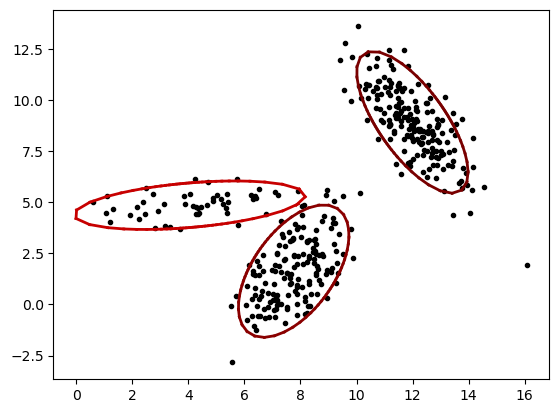

In [44]:
#define number of samples to generate
nData = 400;

#generate data from the mixture of Gaussians
data = mixGaussGen(mixGaussTrue,nData)
print(data.shape)
#draw data, true Gaussians
drawEMData2d(data,mixGaussTrue)

## Estimate MoG using the E-M Algorithm
Here we want to use the E-M algorithm to fit a MoG model to our data points. 

The log likelihood is taken since the raw likelihood value could be too small for our machine's percision.

In [45]:
# This is a function copied from practicalMixGaussA.ipynb
# Returns the likelihood that each data point in data belongs to the Gaussian described by gaussMean and gaussCov
def calcGaussianProb(data,gaussMean,gaussCov):
    diff = data - gaussMean
    norm_const = 1.0 / np.sqrt((2 * np.pi)**data.shape[0] * np.linalg.det(gaussCov))
    exponent = (-0.5)*(diff.T @ np.linalg.inv(gaussCov) @ diff)
    like = norm_const*np.exp(exponent)
    
    return like

In [46]:
def getMixGaussLogLike(data, mixGaussEst): 
    """
    Calculate the log likelihood for the whole dataset under a mixture of Gaussians model.
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.

    Returns: 
    logLike -- scalar containing the log likelihood.
    
    """
    
    data = np.atleast_2d(data)                                                                         
    # find total number of data items                                                                  
    nDims, nData = data.shape                                                                          
    
    # initialize log likelihoods                                                                       
    logLike = 0;                                                                                       
                                                                                                       
    # run through each data item                                                                       
    for cData in range(nData):                                                                                                                                             
        # Calculate likelihood of this data point under mixture of                         
        # Gaussians model.                                                              
        like = 0
        for k in range(mixGaussEst['k']):     
            # like = sum_k(Pr(x,h_i|theta)) = sum_k(lamda_k * Norm_xi(mu_k,cov_k))                                                           
            like = like + mixGaussEst['weight'][k]*calcGaussianProb(data[:, cData] , mixGaussEst['mean'][:, k], mixGaussEst['cov'][:,:,k])
        
        # add to total log like                                                                        
        logLike = logLike + np.log(like)                                                               
                                                                                                       
    return  logLike.item()                                                                       
                                                                                                       

In [47]:
def fitMixGauss(data, k):
    """
    Estimate a k MoG model that would fit the data. Incremently plots the outcome.
               
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    k -- scalar representing the number of gaussians to use in the MoG model.
    
    Returns: 
    mixGaussEst -- dict containing the estimated MoG parameters.
    
    """
    
    #     MAIN E-M ROUTINE  
    #     In the E-M algorithm, we calculate a complete posterior distribution over                                  
    #     the (nData) hidden variables in the E-Step.  
    #     In the M-Step, we update the parameters of the Gaussians (mean, cov, w).   
    
    nDims, nData = data.shape


    postHidden = np.zeros(shape=(k, nData))

    # we will initialize the values to random values
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
        

    # calculate current likelihood
    logLike = getMixGaussLogLike(data, mixGaussEst)
    print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLike))

    nIter = 30;

    logLikeVec = np.zeros(shape=(2 * nIter))
    boundVec = np.zeros(shape=(2 * nIter))

    fig, ax = plt.subplots(1, 1)

    for cIter in range(nIter):

        # ===================== =====================
        # Expectation step
        # ===================== =====================

        for cData in range(nData):
            # Calculate posterior probability that
            # this data point came from each of the Gaussians
            lk = np.zeros(shape=(k, nData))

            for i in range(mixGaussEst['k']):    
               # lik = lamda_k * Norm_xi(mu_k,cov_k)                                                                                      
               lk[i, cData] = mixGaussEst['weight'][i]*calcGaussianProb(data[:, cData] , mixGaussEst['mean'][:, i], mixGaussEst['cov'][:,:,i])

            # r_ik = like/ sum_k(like)
            postHidden[:, cData] = (lk[:, cData]/np.sum(lk[:, cData]))
            

        # ===================== =====================
        # Maximization Step
        # ===================== =====================
        # for each constituent Gaussian
        for cGauss in range(k):
            # Update weighting parameters mixGauss.weight based on the total
            # posterior probability associated with each Gaussian.
            mixGaussEst['weight'][cGauss] = np.sum(postHidden[cGauss, :])/np.sum(postHidden)
            
            
            # Update mean parameters mixGauss.mean by weighted average
            # where weights are given by posterior probability associated with Gaussian.
            mixGaussEst['mean'][:,cGauss] = np.dot(data, postHidden[cGauss, :]) / np.sum(postHidden[cGauss, :])
            
            
            # Update covarance parameter based on weighted average of
            # square distance from update mean, where weights are given by
            # posterior probability associated with Gaussian
            diff = data - mixGaussEst['mean'][:, cGauss].reshape(nDims,1)
            mixGaussEst['cov'][:,:,cGauss] = (postHidden[cGauss,:]*diff)@diff.T / np.sum(postHidden[cGauss, :])
            
            
        # draw the new solution
        drawEMData2d(data, mixGaussEst)
        time.sleep(0.7)
        fig.canvas.draw()

        # calculate the log likelihood
        logLike = getMixGaussLogLike(data, mixGaussEst)
        print('Log Likelihood After Iter {} : {:4.3f}\n'.format(cIter, logLike))


    return mixGaussEst

### Time to put it all together!

Log Likelihood Iter 0 : -6979.814

Log Likelihood After Iter 0 : -1999.051

Log Likelihood After Iter 1 : -1974.097

Log Likelihood After Iter 2 : -1945.641

Log Likelihood After Iter 3 : -1922.322

Log Likelihood After Iter 4 : -1904.714

Log Likelihood After Iter 5 : -1885.783

Log Likelihood After Iter 6 : -1865.632

Log Likelihood After Iter 7 : -1844.734

Log Likelihood After Iter 8 : -1820.742

Log Likelihood After Iter 9 : -1784.971

Log Likelihood After Iter 10 : -1719.245

Log Likelihood After Iter 11 : -1631.380

Log Likelihood After Iter 12 : -1603.012

Log Likelihood After Iter 13 : -1602.951

Log Likelihood After Iter 14 : -1602.948

Log Likelihood After Iter 15 : -1602.946

Log Likelihood After Iter 16 : -1602.945

Log Likelihood After Iter 17 : -1602.944

Log Likelihood After Iter 18 : -1602.944

Log Likelihood After Iter 19 : -1602.944

Log Likelihood After Iter 20 : -1602.943

Log Likelihood After Iter 21 : -1602.943

Log Likelihood After Iter 22 : -1602.943

Log Likel

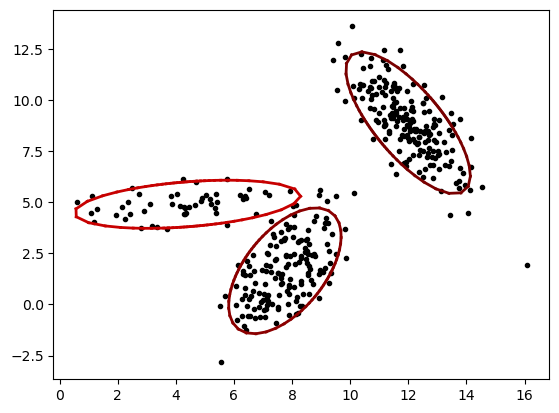

In [48]:
#define number of components to estimate
nGaussEst = 3

#fit mixture of Gaussians 
mixGaussEst = fitMixGauss(data,nGaussEst);

After 30 iterations of the E steps and M steps, the data points are clustered into three groups. The log likelihood stays constant after around 15 iterations, meaning the result will not improve with more iterations, but 30 iterations may be too many, which takes time and computation power. The result MOG distribution is intuitively the same as the ground truth, which matches the expectation.